# Online Retail Data Set - Analysis by Thaer Barakat

- Source of data set: https://archive.ics.uci.edu/dataset/352/online+retail
- Description of data set: This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

## Step 1: Loading and Previewing the Data

In [1]:
#libraries should be pre-installed
#!pip install pandas
#!pip install openpyxl

In [5]:
import pandas as pd

# Load the dataset 
df = pd.read_excel('/Users/thaerb/Downloads/Online Retail.xlsx')

#describe the dataset
print(df.describe())

# Preview the dataset to get a sense of it
df.head()

            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Preview the tail
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


## Step 2: Check for Missing Values and Data Types

In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Check data types
data_types = df.dtypes

# Display the results
print("Missing Values:\n", missing_values)
print("\nData Types:\n", data_types)


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data Types:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


## Step 3: Observations and Cleaning Steps

- **Missing Values**:
    - Description: 1,454 missing values. We could consider removing these rows, as missing descriptions may mean incomplete data for those products.
    - CustomerID: 135,080 missing values. This is significant and likely includes transactions without a customer ID. Since customer segmentation requires customer-specific data, we should consider removing rows where CustomerID is missing.   
<br>  
- **Data Types**:
    - InvoiceDate is already in datetime64[ns] format, which is perfect.
    - CustomerID is a float64, likely due to NaNs, but we’ll cast it to an integer after handling missing values for a cleaner data structure.


In [6]:
# Drop rows with missing CustomerID as these are essential for customer segmentation
df = df.dropna(subset=['CustomerID'])

# Drop rows with missing Description, assuming they are incomplete transactions
df = df.dropna(subset=['Description'])

# Convert CustomerID to integer (after dropping NaNs)
df['CustomerID'] = df['CustomerID'].astype(int)

# Confirm changes by checking for missing values again
df.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Step 4: Analysis

### Feature Engineering for Customer Segmentation

**Total Spend:**
- Calculate the total amount each customer has spent per transaction. This is simply Quantity * UnitPrice.
- Recency, Frequency, and Monetary Value (RFM):
*These three features are essential for customer segmentation:*
    - Recency: The number of days since the customer’s last purchase.
    - Frequency: The total number of purchases by each customer.
    - Monetary Value: The total spend per customer over the dataset period.


In [8]:
# Step 1: Create a Total Spend column
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Step 2: Calculate Recency, Frequency, and Monetary (RFM) values for each customer
import datetime as dt

# Define a snapshot date as the last date in the dataset + 1 day
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalSpend': 'sum'                                       # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpend': 'Monetary'
}, inplace=True)

# Preview the RFM table
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


*Here’s a quick interpretation of each column:*

- **Recency**: Lower values indicate customers who purchased more recently. For instance, Customer 12347 bought something only 2 days before the snapshot date.
- **Frequency**: Higher values show customers who make frequent purchases.
- **Monetary**: Higher values represent customers with a higher total spend.

#### Data Preparation for Clustering
- To prepare for clustering, we’ll standardize the RFM values so that all features are on a similar scale.
- Clustering algorithms like K-means work best when features are scaled.
<br>

1. Standardize the Data:
    - Use StandardScaler from **sklearn** to transform Recency, Frequency, and Monetary into a standard scale.
2. Clustering with K-means:
    - Once the data is standardized, we can apply K-means clustering and find an optimal number of clusters using the **Elbow method**.

In [11]:
#!pip install scikit-learn

In [12]:
from sklearn.preprocessing import StandardScaler

# Standardize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Convert the scaled data back into a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

# Preview the standardized RFM table
rfm_scaled.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,2.322023,-0.329362,-0.231001
12347,-0.893733,0.206102,0.293432
12348,-0.169196,-0.115176,-0.012316
12349,-0.725005,-0.436455,-0.017146
12350,2.163220,-0.436455,-0.190312


#### Steps for Clustering

1. Finding the Optimal Number of Clusters:
    - We’ll use the **Elbow Method** to determine the best number of clusters. This involves running K-means with different cluster counts and plotting the inertia (within-cluster sum of squares) to find the “elbow,” where adding more clusters doesn’t significantly reduce inertia.
2. Applying K-means Clustering:
    - After selecting the optimal number of clusters, we’ll apply **K-means** and assign each customer to a cluster.

In [14]:
#!pip install matplotlib

Matplotlib is building the font cache; this may take a moment.


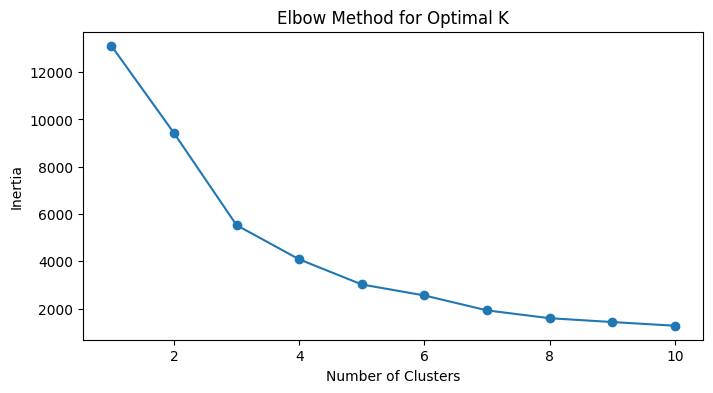

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Use the Elbow Method to find the optimal number of clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


*From the Elbow plot, it looks like the "elbow" point is around **3 or 4** clusters—this is where the inertia (within-cluster sum of squares) starts to decrease at a slower rate, indicating diminishing returns in adding more clusters.*

#### Apply K-means with Optimal Clusters
- We will proceed with 4 clusters (a common choice in RFM analysis) and will see how the segmentation looks:
    - The following code will add a Cluster column to the RFM DataFrame, indicating each customer’s assigned cluster.
    - After running this, we can analyze each cluster's characteristics to interpret the customer segments.

In [16]:
# Apply K-means with the selected number of clusters (4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Check the first few rows with the new Cluster column
rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,2,0.00,1
12347,2,7,4310.00,3
12348,75,4,1797.24,3
12349,19,1,1757.55,3
12350,310,1,334.40,1


#### Analyzing Cluster Characteristics
- Calculate the mean RFM values for each cluster to understand the customer profiles:

In [18]:
# Calculate mean RFM values for each cluster
cluster_summary = rfm.groupby('Cluster').mean()

# View the cluster summary
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,10.752577,28.510309,12168.264691
1,248.927577,1.805942,455.110716
2,5.090909,109.909091,124312.306364
3,42.780906,4.370550,1320.981506


**Here’s an interpretation of each cluster based on the RFM values:**

- Cluster 0:
    - Recency: ~11 days (recent purchases).
    - Frequency: ~28 purchases on average (fairly high frequency).
    - Monetary: Average spend of 12,168 (significant spending).
    - Interpretation: This cluster could represent **"Loyal Customers"** who purchase regularly and spend a good amount.

- Cluster 1:
    - Recency: ~249 days (haven’t purchased recently).
    - Frequency: ~2 purchases on average (low frequency).
    - Monetary: Average spend of 455 (low spending).
    - Interpretation: This cluster might be **"Churned or Lost Customers"** who made a few purchases but have since stopped.

- Cluster 2:
    - Recency: ~5 days (very recent purchases).
    - Frequency: ~110 purchases on average (extremely high frequency).
    - Monetary: Average spend of 124,312 (very high spending).
    - Interpretation: This group could represent **"VIP or Big Spenders"** who purchase very frequently and spend a large amount.

- Cluster 3:
    - Recency: ~43 days (somewhat recent).
    - Frequency: ~4 purchases on average.
    - Monetary: Average spend of 1,321.
    - Interpretation: This cluster may represent **"Potential Loyalists"** who have some recent activity, a moderate number of purchases, and a decent spending level.

#### Label the Clusters: 
- Add labels for each cluster based on the interpretation above.

In [19]:
# Mapping clusters to labels
cluster_labels = {
    0: "Loyal Customers",
    1: "Churned Customers",
    2: "VIP/Big Spenders",
    3: "Potential Loyalists"
}

# Add labels to the DataFrame
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# View the first few rows with the segment labels
rfm.head()


,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346,326,2,0.00,1,Churned Customers
12347,2,7,4310.00,3,Potential Loyalists
12348,75,4,1797.24,3,Potential Loyalists
12349,19,1,1757.55,3,Potential Loyalists
12350,310,1,334.40,1,Churned Customers


#### Visualize the Segments: 
- We will create plots showing:
    - RFM Distribution by Segment: A bar plot showing the average Recency, Frequency, and Monetary values for each segment.
    - Customer Distribution by Segment: A pie chart showing the proportion of customers in each segment.
    - RFM Scatter Plot: A scatter plot to visualize how clusters are separated in terms of RFM values.

In [21]:
#!pip install seaborn

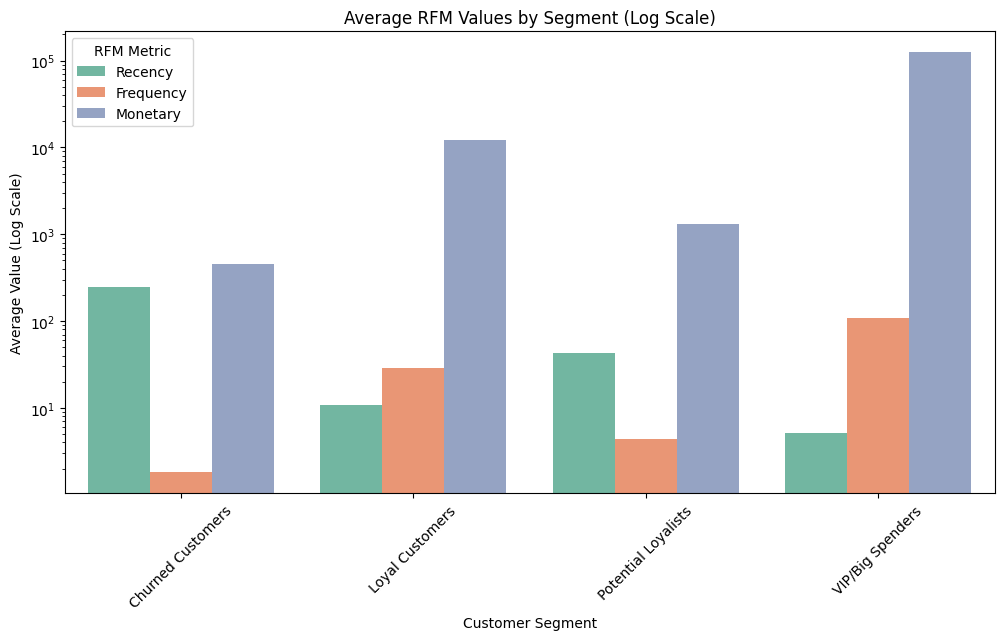

In [27]:
# Create the bar plot with a logarithmic y-scale
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='Value', hue='RFM_Metric', data=rfm_melted, palette="Set2")
plt.yscale('log')
plt.title('Average RFM Values by Segment (Log Scale)')
plt.ylabel('Average Value (Log Scale)')
plt.xlabel('Customer Segment')
plt.legend(title='RFM Metric')
plt.xticks(rotation=45)
plt.show()


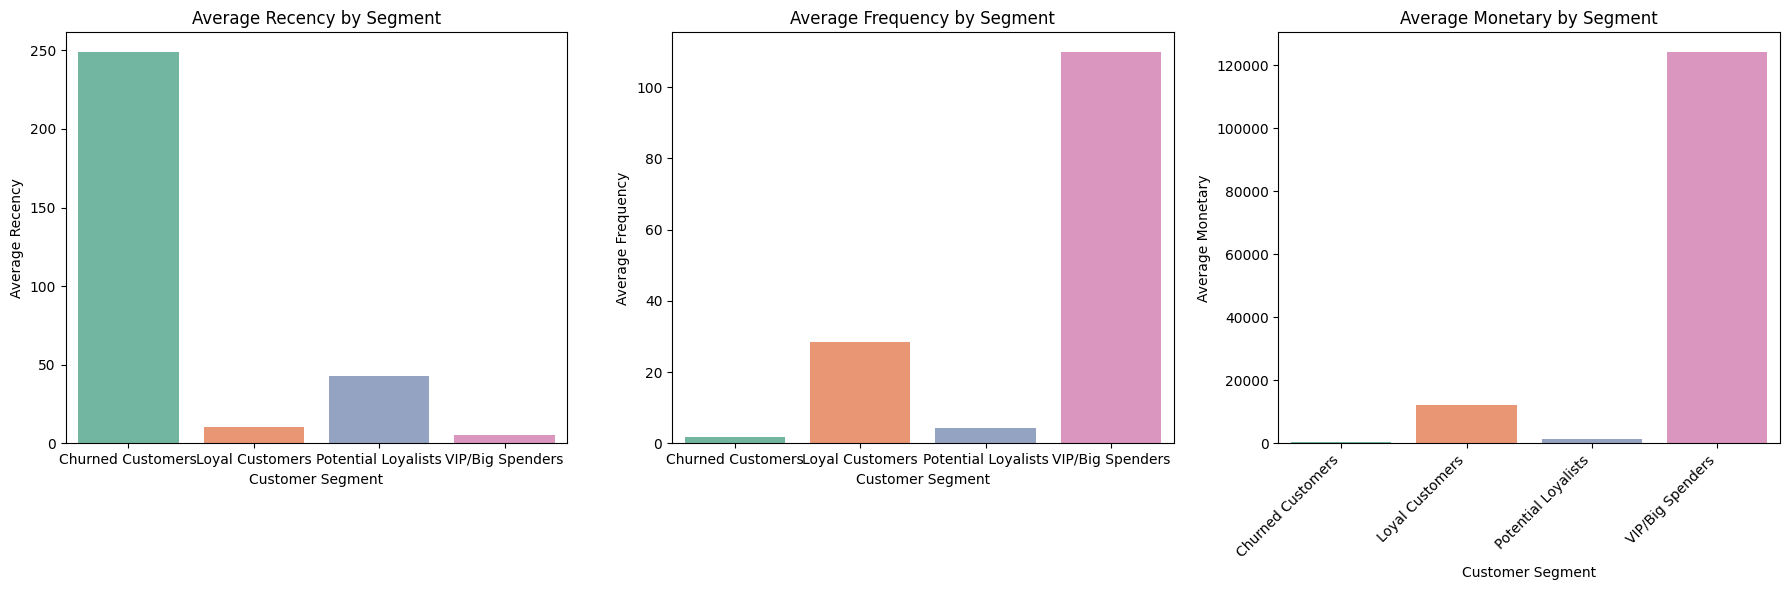

In [32]:
# Set up the figure and create subplots for each RFM metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Plot each RFM metric separately
sns.barplot(x='Segment', y='Recency', data=rfm_means, ax=axes[0], hue='Segment', palette="Set2", legend=False)
axes[0].set_title('Average Recency by Segment')
axes[0].set_ylabel('Average Recency')

sns.barplot(x='Segment', y='Frequency', data=rfm_means, ax=axes[1], hue='Segment', palette="Set2", legend=False)
axes[1].set_title('Average Frequency by Segment')
axes[1].set_ylabel('Average Frequency')

sns.barplot(x='Segment', y='Monetary', data=rfm_means, ax=axes[2], hue='Segment', palette="Set2", legend=False)
axes[2].set_title('Average Monetary by Segment')
axes[2].set_ylabel('Average Monetary')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Customer Segment')
    # Set x-tick labels with a fixed number of ticks
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



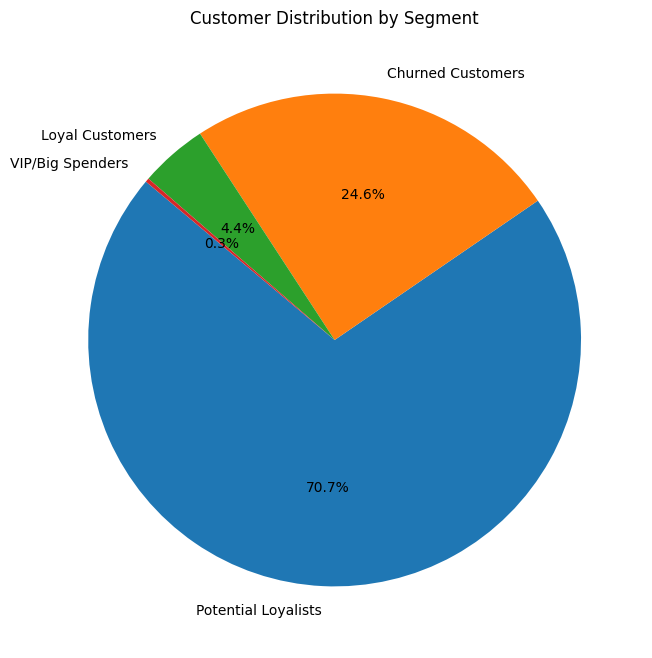

In [23]:
# Count the number of customers in each segment
segment_counts = rfm['Segment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Distribution by Segment')
plt.show()


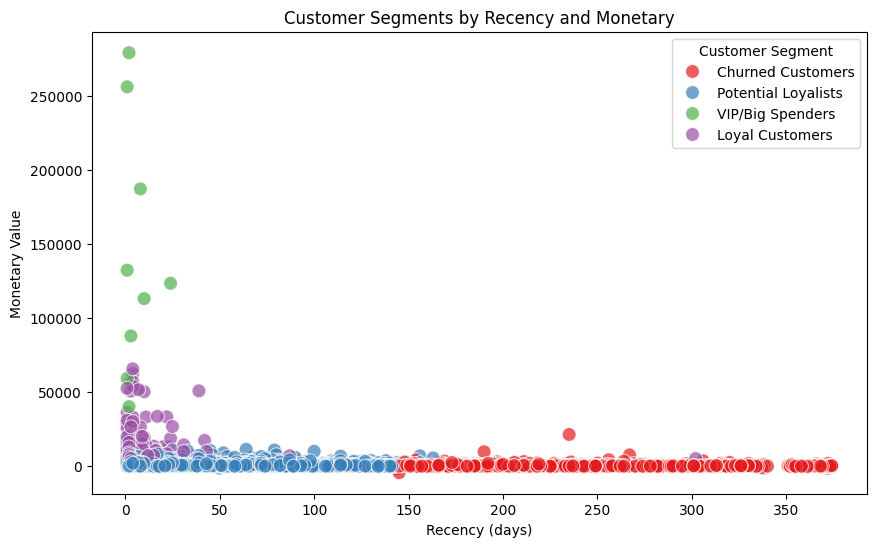

In [24]:
# Scatter plot of Recency vs. Monetary with color by segment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments by Recency and Monetary')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.legend(title='Customer Segment')
plt.show()
